In [202]:
from __future__ import division

import cv2
import sys
import os
import dlib
import glob
import csv
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle 
%matplotlib inline

In [257]:
images = []
labels = []
resize_x = 80
resize_y = 80

In [258]:
def conv2d(x, W):
    return tf.nn.conv2d(
        x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [259]:
with open('../data/convolutional/data.csv', 'rb') as mycsvfile:
    thedata = csv.reader(mycsvfile, delimiter=':')
    thedata.next()
    for row in thedata:
        image = np.fromstring(row[0].replace("[", "").replace("]", ""), dtype=int, sep=" ")
        label = row[1]
        images.append(image)
        labels.append(label)
        tmp_img = np.fliplr(np.array(image).reshape(80,80,3))
        images.append(tmp_img.reshape(-1))
        labels.append(label)

In [260]:
labels = np.array(labels)

In [261]:
df_labels = pd.get_dummies(labels)
labels = np.array(df_labels)

In [262]:
images = np.array(images) / 255

In [263]:
images.shape

(2486, 19200)

In [264]:
images, labels = shuffle(images, labels, random_state=43)

In [265]:
X_train = images[:2000]
Y_train = labels.reshape(len(labels), -1)[:2000]

X_test = images[2000:]
Y_test = labels.reshape(len(labels), -1)[2000:]

In [266]:
# Input and output variables

INPUTS = resize_x * resize_y * 3
OUTPUTS = 2
BATCH_SIZE = 100
NUM_EPOCHS = 300
LEARNING_RATE = 1e-04

In [267]:
try:
    sess.close()
except:
    pass

sess = tf.InteractiveSession()

In [268]:
# Input and output placeholder
x = tf.placeholder(tf.float32, [None, INPUTS])
y = tf.placeholder(tf.float32, [None, OUTPUTS])
pkeep = tf.placeholder(tf.float32)

# First Convolutional Layer
x_image = tf.reshape(x, [-1, resize_x, resize_y, 3])
W_conv_1 = tf.Variable(tf.truncated_normal([2, 2, 3, 8], stddev=0.1))
b_conv_1 = tf.Variable(tf.constant(0.0, shape=[8]))
h_conv_1 = tf.nn.relu(conv2d(x_image, W_conv_1) + b_conv_1)
h_pool_1 = max_pool_2x2(h_conv_1)

# Second Convolutional Layer
W_conv_2 = tf.Variable(tf.truncated_normal([2, 2, 8, 16], stddev=0.1))
b_conv_2 = tf.Variable(tf.constant(0.0, shape=[16]))
h_conv_2 = tf.nn.relu(conv2d(h_pool_1, W_conv_2) + b_conv_2)
h_pool_2 = max_pool_2x2(h_conv_2)

# Third Convolutional Layer
W_conv_3 = tf.Variable(tf.truncated_normal([2, 2, 16, 32], stddev=0.1))
b_conv_3 = tf.Variable(tf.constant(0.0, shape=[32]))
h_conv_3 = tf.nn.relu(conv2d(h_pool_2, W_conv_3) + b_conv_3)
h_pool_3 = max_pool_2x2(h_conv_3)

# Fourth Convolutional Layer
W_conv_4 = tf.Variable(tf.truncated_normal([2, 2, 32, 64], stddev=0.1))
b_conv_4 = tf.Variable(tf.constant(0.0, shape=[64]))
h_conv_4 = tf.nn.relu(conv2d(h_pool_3, W_conv_4) + b_conv_4)
h_pool_4 = max_pool_2x2(h_conv_4)

# Densely connected layer
W_fc1 = tf.Variable(tf.truncated_normal([5 * 5 * 64, 128], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.0, shape=[128]))
h_poolfc1_flat = tf.reshape(h_pool_4, [-1, 5 * 5 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_poolfc1_flat, W_fc1) + b_fc1)

# Densely connected layer
W_fc2 = tf.Variable(tf.truncated_normal([128, 256], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.0, shape=[256]))
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

# Dropout
h_drop = tf.nn.dropout(h_fc2, pkeep)

# Read out Layer
W_fc3 = tf.Variable(tf.truncated_normal([256, OUTPUTS], stddev=0.1))
b_fc3 = tf.Variable(tf.constant(0.0, shape=[OUTPUTS]))
y_logits = tf.matmul(h_drop, W_fc3) + b_fc3
y_softmax = tf.nn.softmax(y_logits)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_logits, y))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
train_step = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_softmax, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.initialize_all_variables()

saver = tf.train.Saver()

sess.run(init)

In [269]:
loss_train_array = []
test_accuracy_array = []
train_accuracy_array = []

for current_epoch in range(NUM_EPOCHS):
    shuffled_index = np.arange(X_train.shape[0])
    np.random.shuffle(shuffled_index)

    train_dataset = X_train[shuffled_index]
    train_labels = Y_train[shuffled_index]

    for step in xrange(int(X_train.shape[0] / BATCH_SIZE)):
        
        offset = step * BATCH_SIZE
        batch_data = train_dataset[offset:(offset + BATCH_SIZE)]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph is should be fed to.
        feed_dict = {x: batch_data, y: batch_labels, pkeep: 0.8}
        _, loss_train = sess.run([train_step, loss],
                                 feed_dict=feed_dict)

    # We calculate the accuracies to plot their values later
    loss_train_array.append(loss_train)
    
    train_accuracy = sess.run(
        accuracy, feed_dict={x: X_train, y: Y_train, pkeep: 1.0})
    
    train_accuracy_array.append(train_accuracy)
    
    test_accuracy = sess.run(
        accuracy, feed_dict={x: X_test, y: Y_test, pkeep: 1.0})
    
    test_accuracy_array.append(test_accuracy)

    print (
        'Epoch %04d, '
        'loss train %.8f, train accuracy %.8f, test accuracy %.8f'
        %
        (current_epoch,
         loss_train,
         train_accuracy,
         test_accuracy))

Epoch 0000, loss train 0.67267156, train accuracy 0.59950000, test accuracy 0.63580245
Epoch 0001, loss train 0.64331007, train accuracy 0.59950000, test accuracy 0.63580245
Epoch 0002, loss train 0.62389052, train accuracy 0.59950000, test accuracy 0.63580245
Epoch 0003, loss train 0.62973505, train accuracy 0.59950000, test accuracy 0.63580245
Epoch 0004, loss train 0.60471064, train accuracy 0.63450003, test accuracy 0.66255146
Epoch 0005, loss train 0.57240498, train accuracy 0.90700001, test accuracy 0.90946501
Epoch 0006, loss train 0.47821835, train accuracy 0.88349998, test accuracy 0.89094651
Epoch 0007, loss train 0.34041664, train accuracy 0.97649997, test accuracy 0.98353910
Epoch 0008, loss train 0.22485557, train accuracy 0.95050001, test accuracy 0.97325104
Epoch 0009, loss train 0.25292048, train accuracy 0.98549998, test accuracy 0.98559672
Epoch 0010, loss train 0.16187976, train accuracy 0.98850000, test accuracy 0.98559672
Epoch 0011, loss train 0.19897446, train ac

In [157]:
#Save model
save_path = saver.save(sess, "/tmp/model_conv_2.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: /tmp/model_conv_2.ckpt


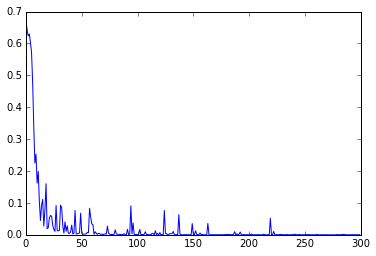

In [270]:
plt.plot(loss_train_array)

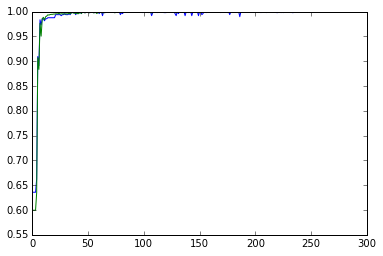

In [271]:
plt.plot(test_accuracy_array)
plt.plot(train_accuracy_array)

In [275]:
video_capture = cv2.VideoCapture(0)
win = dlib.image_window()
detector = dlib.get_frontal_face_detector()
#
tag = ':)'

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    win.clear_overlay()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,'Hola ' + tag + '!!!',(0,130), font, 1, (200,255,155), 2, cv2.LINE_AA)
    
    try:
        win.set_image(frame)
    except:
        pass
    
    win.add_overlay(dlib.rectangle(long(260), long(160), long(420), long(320)))

    dets = detector(frame)

    for k, d in enumerate(dets):

        try:
            img = cv2.resize(frame[d.top():d.top() + d.height(), d.left(): d.left() + d.width()], (resize_x, resize_y),
                             interpolation=cv2.INTER_AREA)

            img = img.reshape(-1).reshape(1, 19200)

            img = np.array(img) / 255

            feed_dict = {x: img, pkeep: 1.0}

            classification = sess.run(y_softmax, feed_dict)

            gabriel_level = classification[0][0]
            david_level = classification[0][1]

            if(gabriel_level > david_level):
                tag = 'Gabriel'
            else:
                tag = 'David'
        except:
            pass

KeyboardInterrupt: 